In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [3]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Some Classification

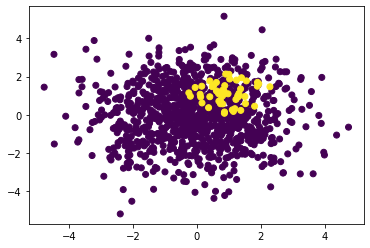

In [4]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

In [5]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
epochs = 10000
learning_rate = 0.01

## CVaR

In [29]:
class CVaRLoss(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = np.searchsorted(sorted_cdf, 1 - self.a, side='left')
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, values_at_risk))
        return values_at_risk

0.7988482713699341
0.6925586462020874
0.6926739811897278
0.6926059722900391
0.6926397085189819
0.6926147937774658
0.6925576329231262
0.6929696798324585
0.6929077506065369
0.6926310658454895
Final loss:  0.6924887299537659


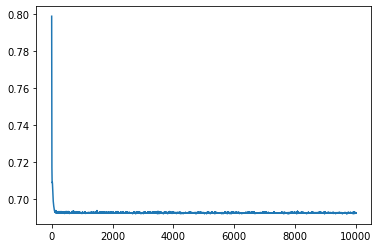

In [267]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.1)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

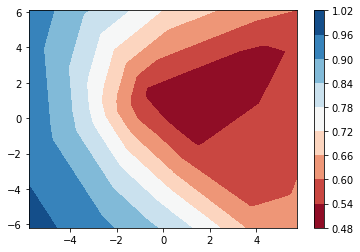

In [268]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## Trimmed Risk

In [401]:
class TrimmedRisk(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _get_untrimmed_losses(self, loss):
        sorted_indices = torch.argsort(loss, dim=0, descending=False)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        return ((empirical_cdf >= self.a) & (empirical_cdf <= 1 - self.a)).nonzero().squeeze()
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        untrimmed_losses = self._get_untrimmed_losses(loss)
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, untrimmed_losses))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, untrimmed_losses))
        return torch.index_select(loss, 0, untrimmed_losses)

0.5300691723823547
0.0006489490042440593
0.0002975804090965539
0.00018812116468325257
0.00013583575491793454
0.0001055117609212175
8.586106559960172e-05
7.213609205791727e-05
6.203964585438371e-05
5.4320862545864657e-05
Final loss:  4.824368079425767e-05


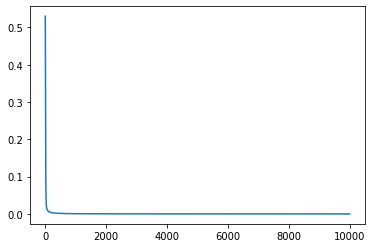

In [406]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = TrimmedRisk(a=0.05)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

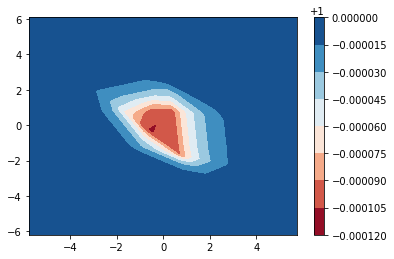

In [407]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## Mean-variance

In [316]:
class MeanVariance(nn.Module):
    def __init__(self, c=0, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.c = c
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        var, mean = torch.var_mean(loss, unbiased=False)
        
        return mean + torch.mul(var, self.c)

0.7088884115219116
0.2720114588737488
0.26575708389282227
0.2623119652271271
0.2604674696922302
0.25936371088027954
0.2585986852645874
0.25802838802337646
0.2575928270816803
0.25719285011291504
Final loss:  0.25678274035453796


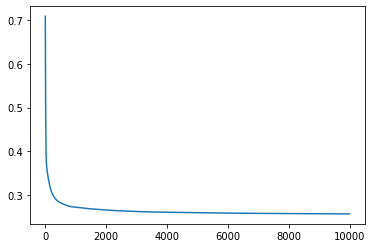

In [330]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = MeanVariance(c=2)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

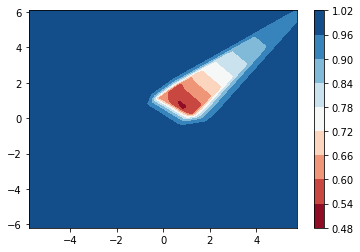

In [331]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Random Labels

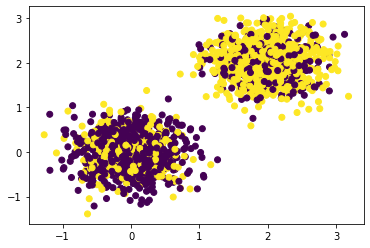

In [10]:
n_samples_1 = 1000
n_samples_2 = 1000
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.3
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## CVaR

In [11]:
class CVaRLoss(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = np.searchsorted(sorted_cdf, 1 - self.a, side='left')
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, values_at_risk))
        return torch.index_select(loss, 0, values_at_risk)

0.8506212830543518
0.6680968999862671
0.6648858785629272
0.664725124835968
0.6649559140205383
0.6644980311393738
0.6653609275817871
0.6636878848075867
0.6640596985816956
0.6647745966911316
Final loss:  0.6638038158416748


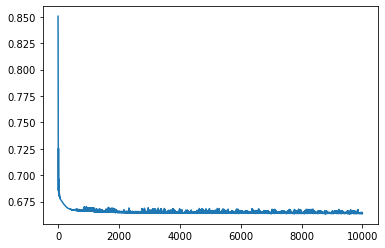

In [12]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.75)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

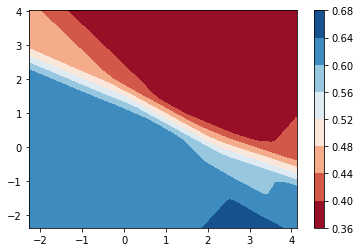

In [13]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 2000)


(0.0, 2000.0)

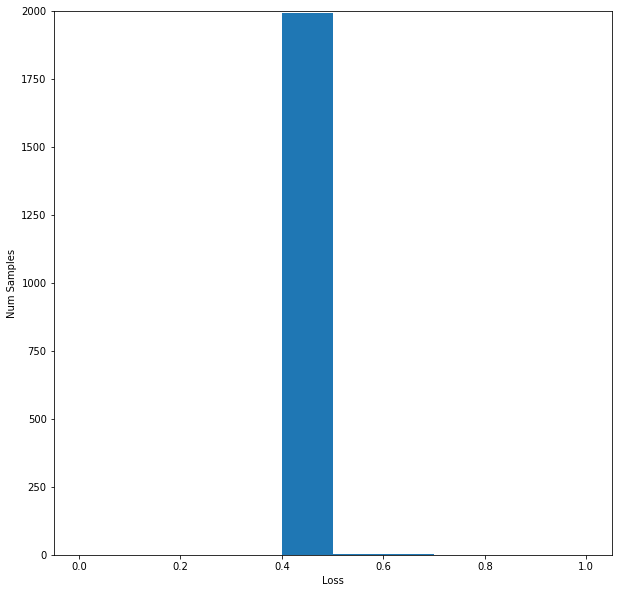

In [299]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    loss = criterion(output, labels_orig.squeeze(1).type(torch.LongTensor))
    print('Num losses > 0.4:', np.array(np.where(loss > 0.4)).shape)
    losses.append(loss)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1])
plt.ylim((None, 2000))

## Trimmed Risk

0.6263439059257507
0.0017251550452783704
0.000785547832492739
0.0004980288213118911
0.0003611300780903548
0.0002818526409100741
0.00023035045887809247
0.0001943371316883713
0.00016778001736383885
0.00014742411440238357
Final loss:  0.00013134970504324883


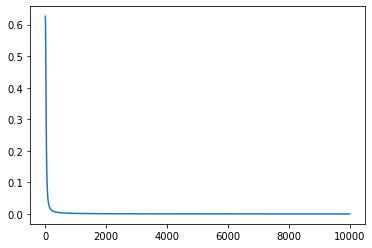

In [416]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = TrimmedRisk(a=0.3)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

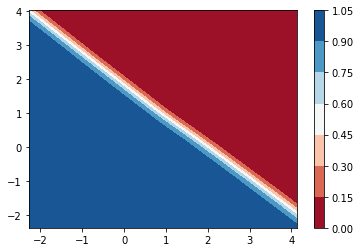

In [417]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

[tensor([2.2292e-05, 1.2517e-05, 5.6028e-06,  ..., 1.4305e-06, 4.3153e-05,
        2.9802e-06])]


(0.0, 2000.0)

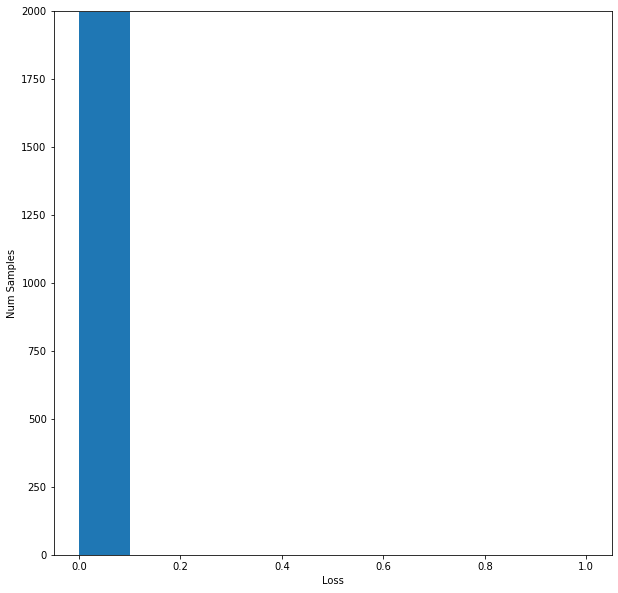

In [418]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    loss = criterion(output, labels_orig.squeeze(1).type(torch.LongTensor))
    losses.append(loss)
print(losses)
plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

## Mean-variance

In [364]:
class MeanVariance(nn.Module):
    def __init__(self, c=0, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.c = c
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        var, mean = torch.var_mean(loss, unbiased=False)
        return mean + torch.mul(var, self.c)

0.7169377207756042
0.6364670395851135
0.6354186534881592
0.6351017951965332
0.6348202228546143
0.6347020268440247
0.634625256061554
0.6345434784889221
0.6344371438026428
0.6343326568603516
Final loss:  0.6342588067054749


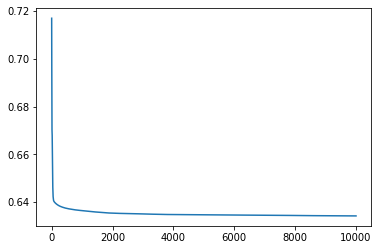

In [366]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = MeanVariance(c=0.1)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

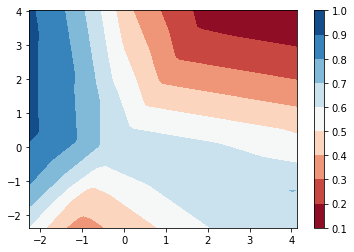

In [367]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 1444)


(0.0, 2000.0)

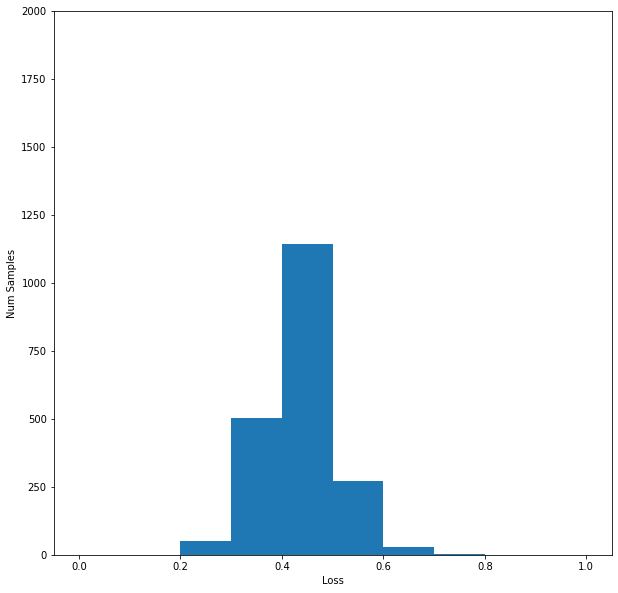

In [370]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    for i in range(len(inputs)):
        output = model(inputs[i])
        output = output[None, :]
        loss = criterion(output, labels_orig[i].type(torch.LongTensor))
        losses.append(loss.item())
        
print('Num losses > 0.4:', np.array(np.where(np.array(losses) > 0.4)).shape)
plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

# Class Imbalance

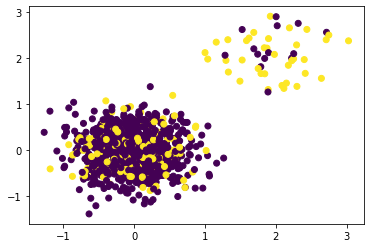

In [448]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.2
n = len(y)
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## CVaR

In [301]:
class CVaRLoss(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = min(np.searchsorted(sorted_cdf, 1 - self.a, side='left'), len(sorted_cdf) - 1)
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, values_at_risk))
        return torch.index_select(loss, 0, values_at_risk)

0.6794899106025696
0.5657567977905273
0.5649589896202087
0.5646170973777771
0.5642838478088379
0.5630888938903809
0.5628809332847595
0.562603771686554
0.5621185302734375
0.5617355704307556
Final loss:  0.561555027961731


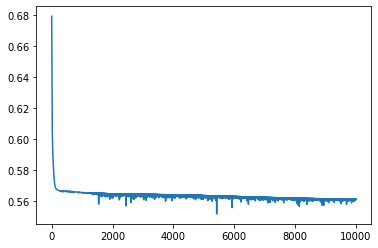

In [450]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.75)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

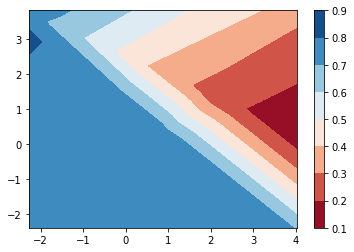

In [451]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

(0.0, 2000.0)

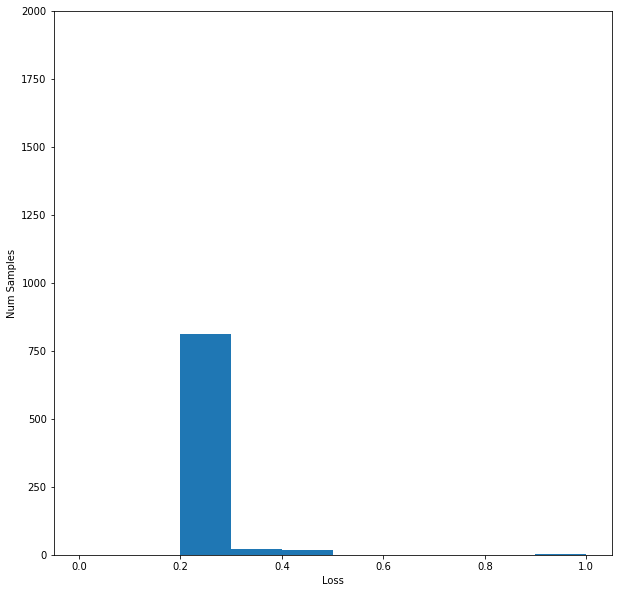

In [452]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1])
plt.ylim((None, 2000))

## Trimmed Risk

0.7873424887657166
0.4143238961696625
0.4126727283000946
0.4098344147205353
0.40638798475265503
0.40375158190727234
0.4015182554721832
0.39980703592300415
0.3985089957714081
0.3975362181663513
Final loss:  0.3967922627925873


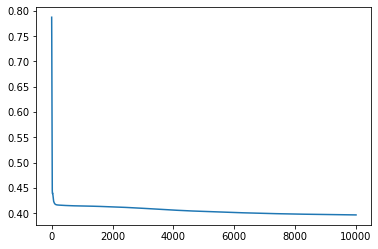

In [484]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = TrimmedRisk(a=0.05)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

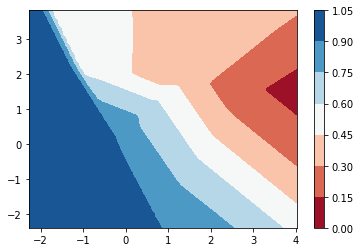

In [485]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

(0.0, 2000.0)

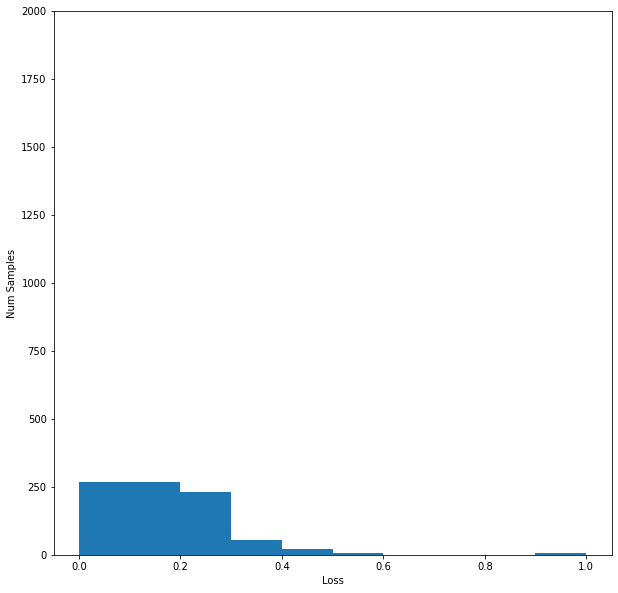

In [486]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

## Mean-variance

0.6349487900733948
0.5198034048080444
0.5192105770111084
0.518673300743103
0.5183667540550232
0.5180895328521729
0.5178830623626709
0.5176511406898499
0.517509400844574
0.517371416091919
Final loss:  0.5172332525253296


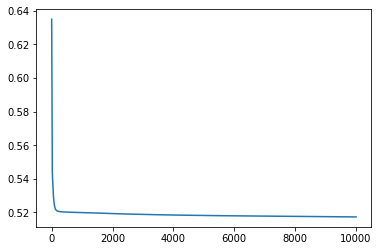

In [445]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = MeanVariance(c=0.1)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

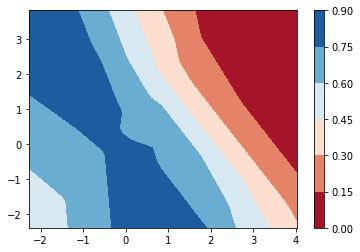

In [446]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

(array([  3.,  29., 677., 129.,   7.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

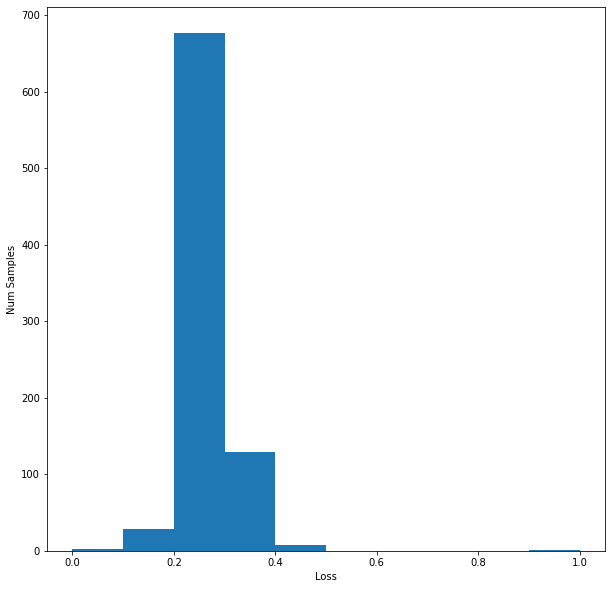

In [447]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    for i in range(len(inputs)):
        output = model(inputs[i])
        output = output[None, :]
        loss = criterion(output, labels[i].type(torch.LongTensor))
        losses.append(loss.item())
        
plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

# Fair Regression

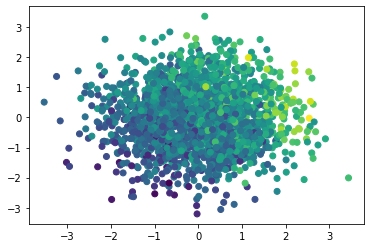

In [23]:
num_train = 2000
DATA_DIM = 5

X_train = np.random.normal(loc=0, scale=1, size=(num_train, DATA_DIM))
eps_train = np.random.normal(loc=0, scale=0.01, size=(num_train, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
y_train = np.array([X_train[i].dot(theta) + eps_train[i] if X_train[i][0] <= 1.645 else X_train[i].dot(theta) + X_train[i][0] + eps_train[i] for i in range(num_train)])

plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

y_train = y_train.reshape(-1, 1)
inputs = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train, dtype=torch.float)

In [24]:
num_test = 20000

X_test = np.random.normal(loc=0, scale=1, size=(num_test, DATA_DIM))
eps_test = np.random.normal(loc=0, scale=0.01, size=(num_test, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
is_majority = [False if X_test[i][0] > 1.645 else True for i in range(num_test)]
y_test = np.array([X_test[i].dot(theta) + eps_test[i] if X_test[i][0] <= 1.645 else X_test[i].dot(theta) + X_test[i][0] + eps_test[i] for i in range(num_test)])
y_test = y_test.reshape(-1, 1)

In [25]:
input_size = DATA_DIM
h1 = 50
h2 = 25
epochs = 200

class RegressionMLP(nn.Module):
    def __init__(self, input_size, h1, h2):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## ERM

In [26]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

5.212076187133789
Final training loss:  0.058227378875017166
Majority Risk: 0.04671740159392357
Minority Risk: 0.4666004478931427


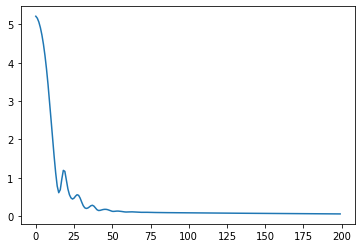

In [27]:
criterion = nn.MSELoss(reduction='mean')

model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.type(torch.float32))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", losses[-1])
plt.plot(losses)

model.eval()
majority_losses = []
minority_losses = []

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        # negative likelihood (expected risk)
        loss = criterion(output, torch.tensor(y, dtype=torch.float32))
        if is_majority[i]:
            majority_losses.append(loss)
        else:
            minority_losses.append(loss)
            
erm_majority_risk = torch.mean(torch.tensor(majority_losses)).item()
erm_minority_risk = torch.mean(torch.tensor(minority_losses)).item()
print('Majority Risk:', erm_majority_risk)
print('Minority Risk:', erm_minority_risk)

## CVaR

Final training loss for a=0.05
Majority Risk For a=0.05: 0.05862882360816002
Minority Risk For a=0.05: 0.32888415455818176
Final training loss for a=0.1
Majority Risk For a=0.1: 0.02879771776497364
Minority Risk For a=0.1: 0.33781588077545166
Final training loss for a=0.15000000000000002
Majority Risk For a=0.15000000000000002: 0.020514627918601036
Minority Risk For a=0.15000000000000002: 0.3458714187145233
Final training loss for a=0.2
Majority Risk For a=0.2: 0.019259072840213776
Minority Risk For a=0.2: 0.3412736654281616
Final training loss for a=0.25
Majority Risk For a=0.25: 0.020706884562969208
Minority Risk For a=0.25: 0.3292867839336395
Final training loss for a=0.3
Majority Risk For a=0.3: 0.022364608943462372
Minority Risk For a=0.3: 0.32423654198646545
Final training loss for a=0.35000000000000003
Majority Risk For a=0.35000000000000003: 0.024368738755583763
Minority Risk For a=0.35000000000000003: 0.3191286325454712
Final training loss for a=0.4
Majority Risk For a=0.4: 0.

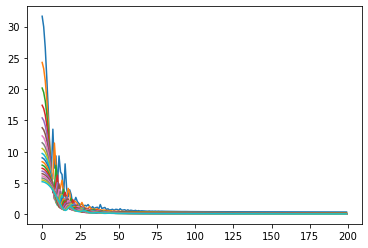

In [30]:
alphas = np.arange(0.05, 1.05, 0.05)

majority_risks = []
minority_risks = []

for a in alphas:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = CVaRLoss(a=a, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)
        # negative likelihood (expected risk)
        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for a={}".format(a, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For a={}: {}'.format(a, majority_risks[-1]))
    print('Minority Risk For a={}: {}'.format(a, minority_risks[-1]))

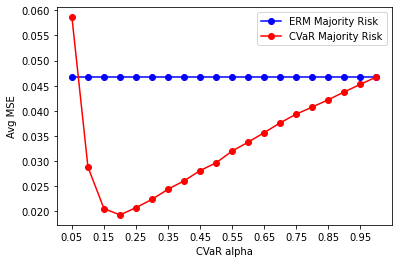

In [31]:
plt.plot(alphas, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(alphas, majority_risks, marker='o', color='r', label='CVaR Majority Risk')
plt.xlabel('CVaR alpha')
plt.xticks(np.arange(0.05, 1.05, 0.1))
plt.ylabel('Avg MSE')
plt.legend()

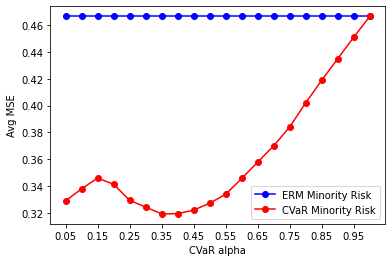

In [32]:
plt.plot(alphas, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(alphas, minority_risks, marker='o', color='r', label='CVaR Minority Risk')
plt.xlabel('CVaR alpha')
plt.xticks(np.arange(0.05, 1.05, 0.1))
plt.ylabel('Avg MSE')
plt.legend()

## Trimmed Risk

Final training loss for a=0.0
Majority Risk For a=0.0: 0.04671740159392357
Minority Risk For a=0.0: 0.4666004478931427
Final training loss for a=0.01
Majority Risk For a=0.01: 0.04390115290880203
Minority Risk For a=0.01: 0.7044882774353027
Final training loss for a=0.02
Majority Risk For a=0.02: 0.036593660712242126
Minority Risk For a=0.02: 1.1739259958267212
Final training loss for a=0.03
Majority Risk For a=0.03: 0.026979217305779457
Minority Risk For a=0.03: 1.7813231945037842
Final training loss for a=0.04
Majority Risk For a=0.04: 0.014665531925857067
Minority Risk For a=0.04: 2.6342222690582275
Final training loss for a=0.05
Majority Risk For a=0.05: 0.007079152390360832
Minority Risk For a=0.05: 3.9093236923217773
Final training loss for a=0.06
Majority Risk For a=0.06: 0.008243526332080364
Minority Risk For a=0.06: 4.331914901733398
Final training loss for a=0.07
Majority Risk For a=0.07: 0.010587388649582863
Minority Risk For a=0.07: 4.373319625854492
Final training loss for

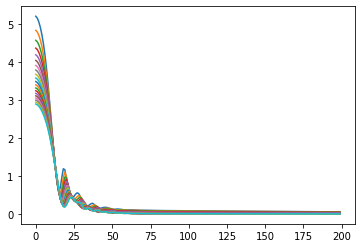

In [395]:
alphas = np.arange(0, 0.2, 0.01)

majority_risks = []
minority_risks = []

for a in alphas:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = TrimmedRisk(a=a, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)
        # negative likelihood (expected risk)
        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for a={}".format(a, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For a={}: {}'.format(a, majority_risks[-1]))
    print('Minority Risk For a={}: {}'.format(a, minority_risks[-1]))

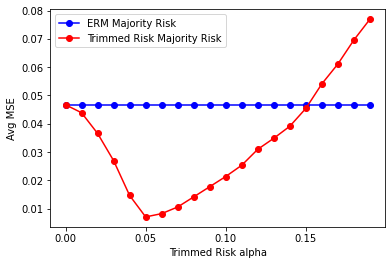

In [396]:
plt.plot(alphas, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(alphas, majority_risks, marker='o', color='r', label='Trimmed Risk Majority Risk')
plt.xlabel('Trimmed Risk alpha')
plt.xticks(np.arange(0.0, 0.2, 0.05))
plt.ylabel('Avg MSE')
plt.legend()

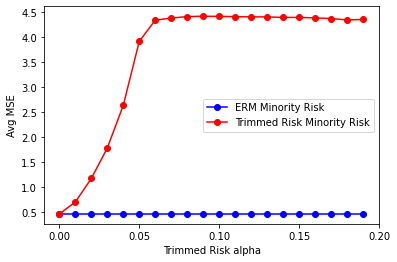

In [397]:
plt.plot(alphas, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(alphas, minority_risks, marker='o', color='r', label='Trimmed Risk Minority Risk')
plt.xlabel('Trimmed Risk alpha')
plt.xticks(np.arange(0.0, 0.25, 0.05))
plt.ylabel('Avg MSE')
plt.legend()

## Mean Variance

In [254]:
class MeanVariance(nn.Module):
    def __init__(self, c=0, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.c = c
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        var, mean = torch.var_mean(loss, unbiased=False)
        
        return mean + torch.mul(var, self.c)

Final training loss for c=0.05
Majority Risk For c=0.05: 0.04417907074093819
Minority Risk For c=0.05: 0.41846489906311035
Final training loss for c=0.1
Majority Risk For c=0.1: 0.04315926879644394
Minority Risk For c=0.1: 0.3934096097946167
Final training loss for c=0.15000000000000002
Majority Risk For c=0.15000000000000002: 0.04166765511035919
Minority Risk For c=0.15000000000000002: 0.3800487816333771
Final training loss for c=0.2
Majority Risk For c=0.2: 0.04058224707841873
Minority Risk For c=0.2: 0.37853100895881653
Final training loss for c=0.25
Majority Risk For c=0.25: 0.03963145613670349
Minority Risk For c=0.25: 0.37042349576950073
Final training loss for c=0.3
Majority Risk For c=0.3: 0.036540284752845764
Minority Risk For c=0.3: 0.35564717650413513
Final training loss for c=0.35000000000000003
Majority Risk For c=0.35000000000000003: 0.03428809717297554
Minority Risk For c=0.35000000000000003: 0.3478735387325287
Final training loss for c=0.4
Majority Risk For c=0.4: 0.033

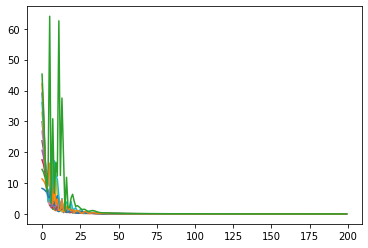

In [255]:
cs = np.arange(0.05, 0.7, 0.05)

majority_risks = []
minority_risks = []

for c in cs:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = MeanVariance(c, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)

        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for c={}".format(c, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For c={}: {}'.format(c, majority_risks[-1]))
    print('Minority Risk For c={}: {}'.format(c, minority_risks[-1]))

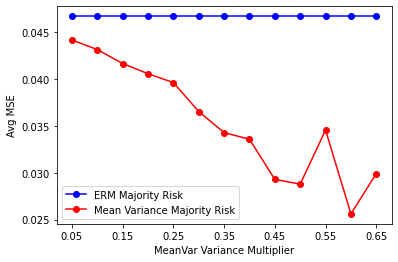

In [256]:
plt.plot(cs, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(cs, majority_risks, marker='o', color='r', label='Mean Variance Majority Risk')
plt.xlabel('MeanVar Variance Multiplier')
plt.xticks(np.arange(0.05, 0.7, 0.1))
plt.ylabel('Avg MSE')
plt.legend()

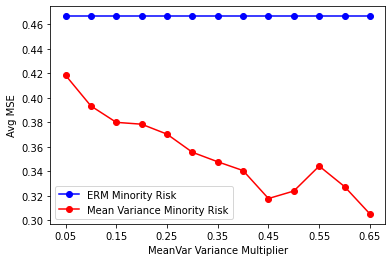

In [257]:
plt.plot(cs, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(cs, minority_risks, marker='o', color='r', label='Mean Variance Minority Risk')
plt.xlabel('MeanVar Variance Multiplier')
plt.xticks(np.arange(0.05, 0.7, 0.1))
plt.ylabel('Avg MSE')
plt.legend()